In [9]:
import rpy2
print(rpy2.__version__)

3.5.11


In [16]:
%load_ext rpy2.ipython # 激活 R 和 Python 相互调用

In [17]:
%matplotlib inline

from prophet import Prophet
import pandas as pd
import logging
import warnings

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [20]:
%%R
library(tidyverse)
library(prophet)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 1.0.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%@%()         masks rlang::%@%()
✖ dplyr::filter()      masks stats::filter()
✖ purrr::flatten()     masks rlang::flatten()
✖ purrr::flatten_chr() masks rlang::flatten_chr()
✖ purrr::flatten_dbl() masks rlang::flatten_dbl()
✖ purrr::flatten_int() masks rlang::flatten_int()
✖ purrr::flatten_lgl() masks rlang::flatten_lgl()
✖ purrr::flatten_raw() masks rlang::flatten_raw()
✖ purrr::invoke()      masks rlang::invoke()
✖ dplyr::lag()         masks stats::lag()
✖ purrr::splice()      masks rlang::splice()



There are two main ways that outliers can affect Prophet forecasts. Here we make a forecast on the logged Wikipedia visits to the R page from before, but with a block of bad data:

R[write to console]: Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



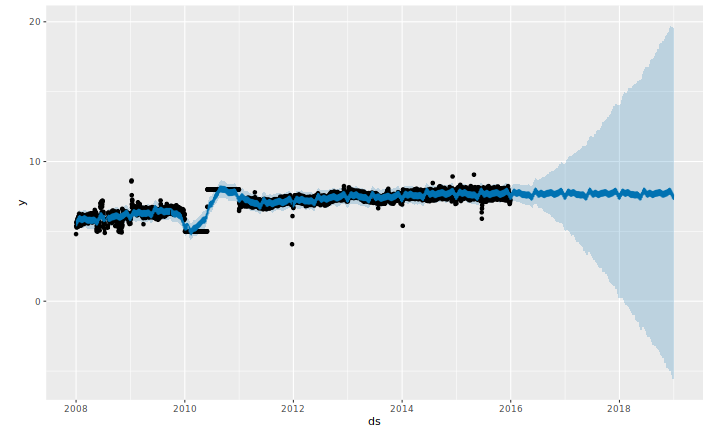

In [24]:
%%R -w 10 -h 6 -u in
# df <- read.csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers1.csv')
df <- read.csv('../datasets/example_wp_log_R_outliers1.csv')
m <- prophet(df)
future <- make_future_dataframe(m, periods = 1096)
forecast <- predict(m, future)
plot(m, forecast)

20:42:15 - cmdstanpy - INFO - Chain [1] start processing
20:42:16 - cmdstanpy - INFO - Chain [1] done processing


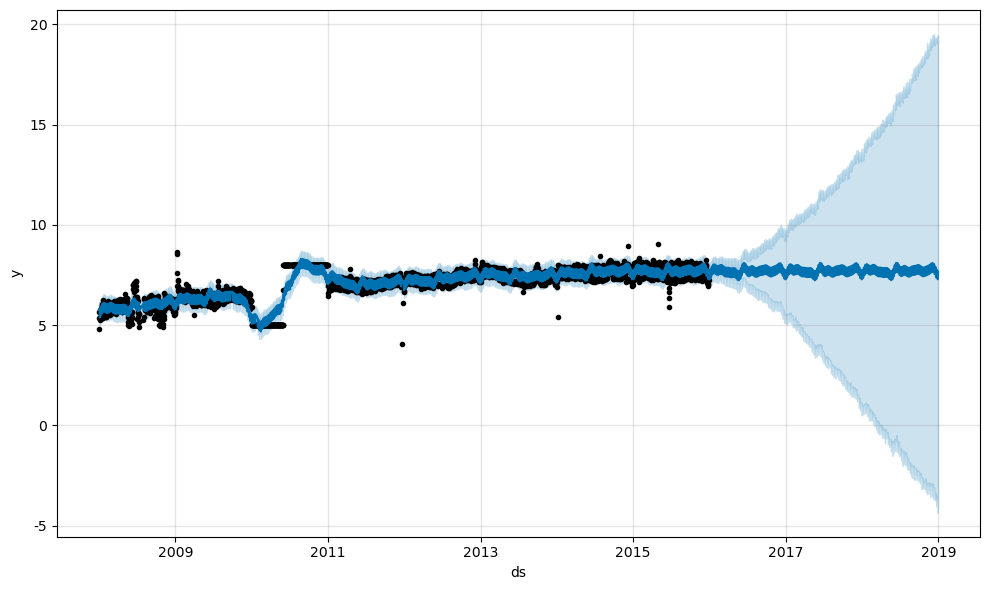

In [26]:
df = pd.read_csv('../datasets/example_wp_log_R_outliers1.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)

The trend forecast seems reasonable, but the uncertainty intervals seem way too wide. Prophet is able to handle the outliers in the history, but only by fitting them with trend changes. The uncertainty model then expects future trend changes of similar magnitude.

The best way to handle outliers is to remove them - Prophet has no problem with missing data. If you set their values to `NA` in the history but leave the dates in `future`, then Prophet will give you a prediction for their values.

R[write to console]: Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



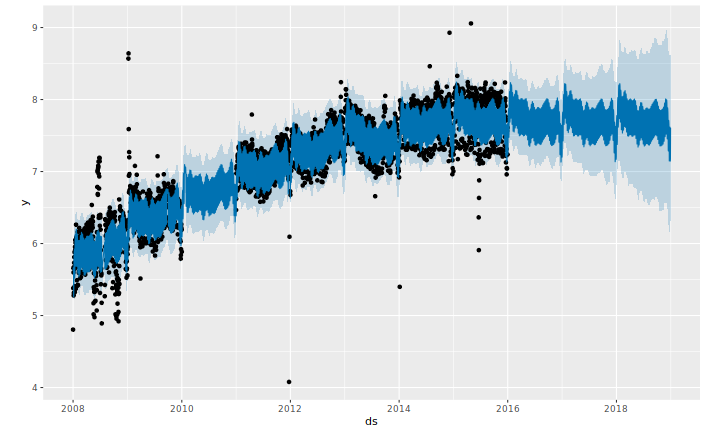

In [27]:
%%R -w 10 -h 6 -u in
outliers <- (as.Date(df$ds) > as.Date('2010-01-01')
             & as.Date(df$ds) < as.Date('2011-01-01'))
df$y[outliers] = NA
m <- prophet(df)
forecast <- predict(m, future)
plot(m, forecast)

20:45:27 - cmdstanpy - INFO - Chain [1] start processing
20:45:27 - cmdstanpy - INFO - Chain [1] done processing


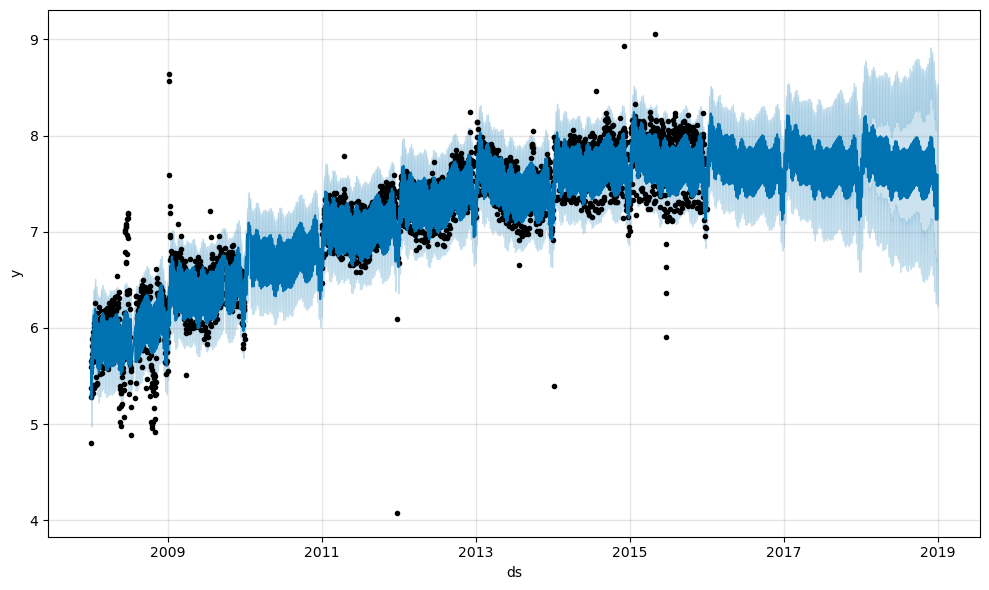

In [28]:
df.loc[(df['ds'] > '2010-01-01') & (df['ds'] < '2011-01-01'), 'y'] = None
model = Prophet().fit(df)
fig = model.plot(model.predict(future))

In the above example the outliers messed up the uncertainty estimation but did not impact the main forecast `yhat`. This isn't always the case, as in this example with added outliers:

R[write to console]: Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



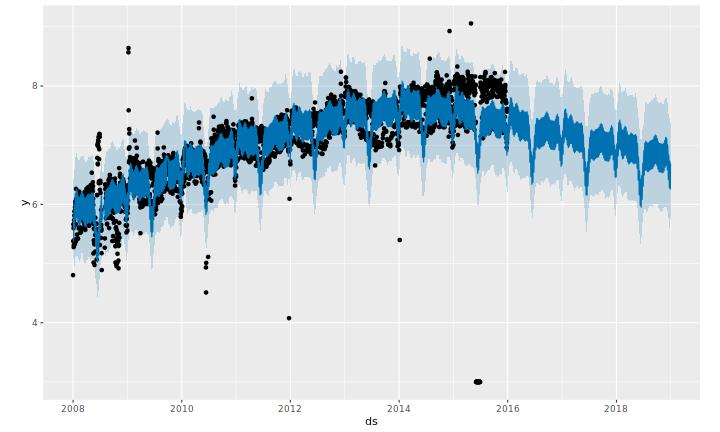

In [29]:
%%R -w 10 -h 6 -u in
# df <- read.csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers2.csv')
df <- read.csv('../datasets/example_wp_log_R_outliers2.csv')
m <- prophet(df)
future <- make_future_dataframe(m, periods = 1096)
forecast <- predict(m, future)
plot(m, forecast)

20:46:13 - cmdstanpy - INFO - Chain [1] start processing
20:46:14 - cmdstanpy - INFO - Chain [1] done processing


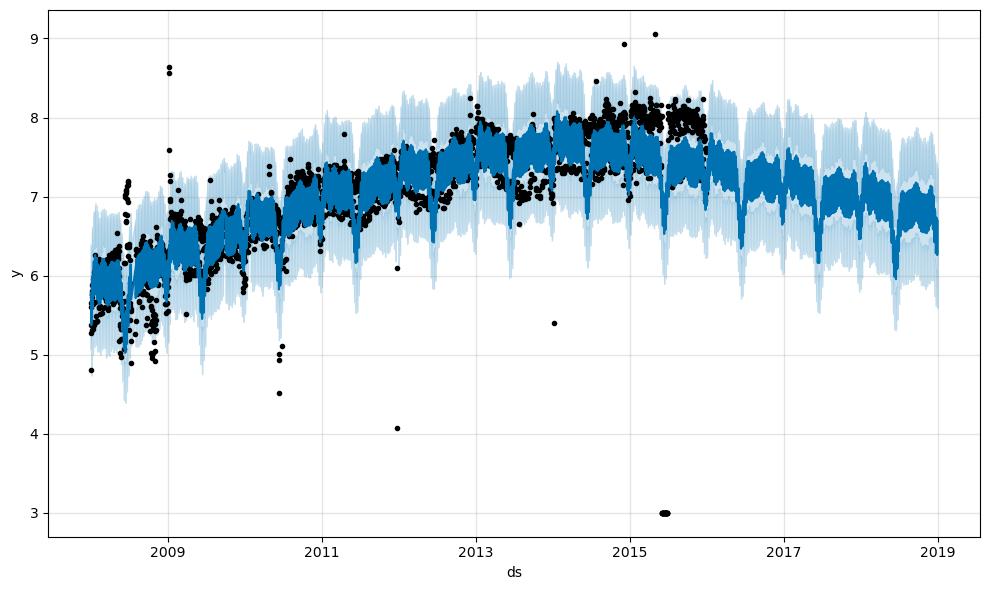

In [32]:
df = pd.read_csv('../datasets/example_wp_log_R_outliers2.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)

Here a group of extreme outliers in June 2015 mess up the seasonality estimate, so their effect reverberates into the future forever. Again the right approach is to remove them:

R[write to console]: Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



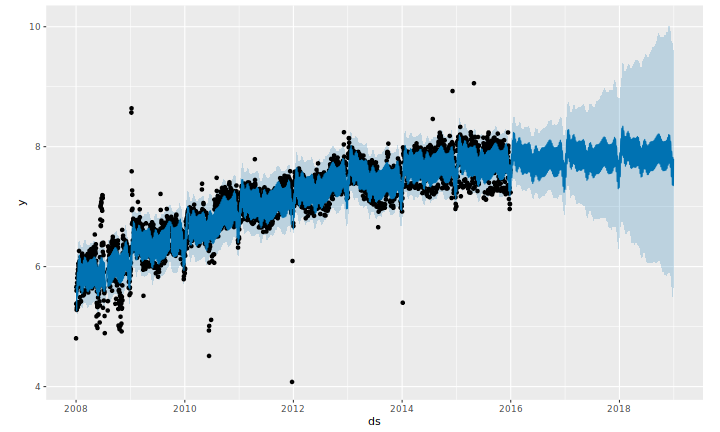

In [33]:
%%R -w 10 -h 6 -u in
outliers <- (as.Date(df$ds) > as.Date('2015-06-01')
             & as.Date(df$ds) < as.Date('2015-06-30'))
df$y[outliers] = NA
m <- prophet(df)
forecast <- predict(m, future)
plot(m, forecast)

20:46:34 - cmdstanpy - INFO - Chain [1] start processing
20:46:35 - cmdstanpy - INFO - Chain [1] done processing


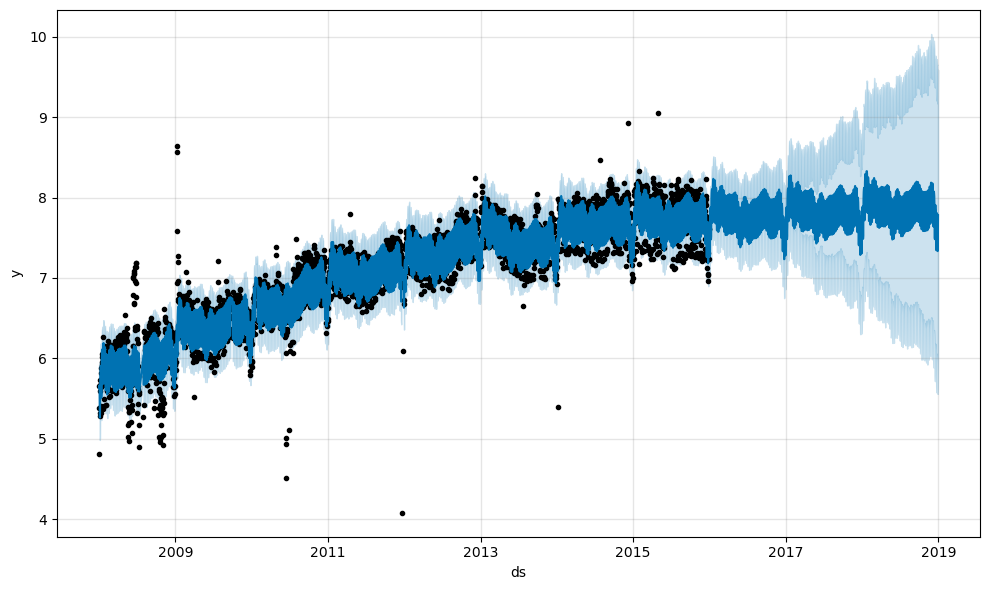

In [34]:
df.loc[(df['ds'] > '2015-06-01') & (df['ds'] < '2015-06-30'), 'y'] = None
m = Prophet().fit(df)
fig = m.plot(m.predict(future))